# Section 01

In [1]:
import subprocess as proc
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme("notebook", "whitegrid", rc={"figure.dpi": 130})

# Base directory for stored data
root = Path("..")

# Base directory for the random generator seed and primes files
rng_dir = root / "data"
# Directory in which run results are/will be stored
data_dir = root / "results" / "01"


## Exercise 01.1

Testing RANNYU computing some statistics on the random sampler

In [2]:
ex = "01_1"

# Path to the executable
executable = root / "bin" / ex
stats_file = lambda seed: data_dir / f"{ex}_{seed}_stats.csv"
chi_file = lambda seed: data_dir / f"{ex}_{seed}_chi.csv"

prime_lines = [1, 9, 16, 25]
# The program is run using the following parameters:
BLOCK_SIZE = int(1e3)
N_BLOCKS = int(1e2)
N_INTERVALS = int(1e2)
N_TRIALS = int(1e3)
for prime_line in prime_lines:
    proc.run(
        [
            executable,
            f"--primes_path={rng_dir/'primes'/'Primes'}",
            f"--seeds_path={rng_dir/'seeds'/'seed.in'}",
            f"--primes_line={prime_line}",
            f"--block_size={BLOCK_SIZE}",
            f"--n_blocks={N_BLOCKS}",
            f"--n_trials={N_TRIALS}",
            f"--n_intervals={N_INTERVALS}",
            f"--out1={stats_file(prime_line)}",
            f"--out2={chi_file(prime_line)}",
        ]
    )

# Pandas DataFrames storing respectively mean and variance block estimations, with uncertainties...
stats_data = [pd.read_csv(stats_file(prime_line)) for prime_line in prime_lines]
# ... and Pearson's X^2
chi_data = [pd.read_csv(chi_file(prime_line)) for prime_line in prime_lines]


In [3]:
# displaying the format the data is saved in
stats_data[0].head()


,mean_estimate,mean_error,variance_estimate,variance_error
0,0.499702,0.000000,0.083092,0.000000
1,0.499283,0.000419,0.082896,0.000196
2,0.505534,0.006256,0.083881,0.000992
3,0.502651,0.005280,0.085009,0.001328
4,0.502760,0.004092,0.084760,0.001059


In [4]:
chi_data[0].head().transpose()


,0,1,2,3,4
X^2,90.48,84.94,101.16,102.86,105.04


### Expectation value and variance of the random generator

The RANNYU procedure is used to generate random values $r \in [0,1)$. It being a uniform generator we expect $\langle r \rangle = 0.5$ and $\sigma^2_r = \frac{1}{12}$.
To test that successive batches of random values were extracted and passed to the sample average and sample variance, which are unbiased estimators of $\langle r \rangle$ and $\sigma^2_r$. To give a measure of the statistical uncertainty the blocking method was used.

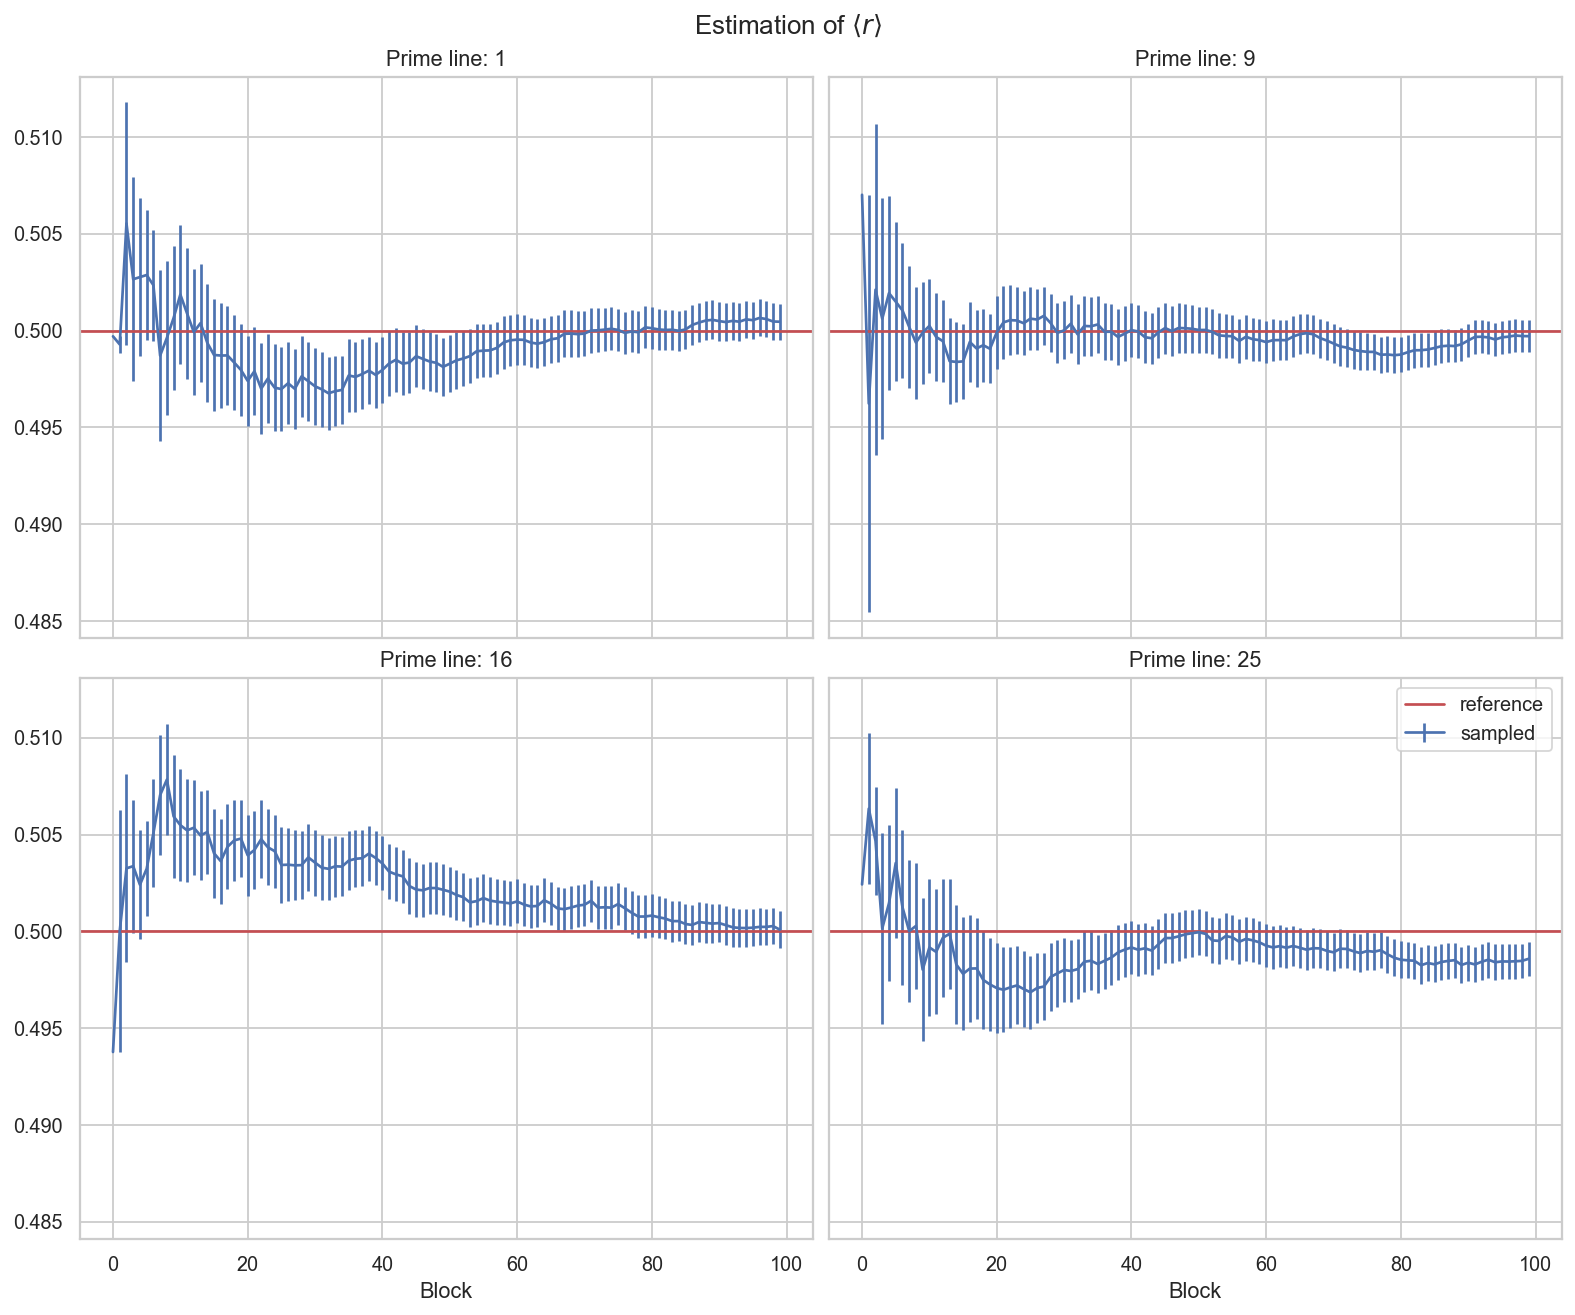

In [5]:
# Plotting four rounds of mean estimations with uncertainties
fig, axes = plt.subplots(
    2, 2, sharex=True, sharey=True, figsize=(12, 10), constrained_layout=True
)
for p_l, df, ax in zip(prime_lines, stats_data, axes.flatten()):
    ax.errorbar(
        "block",
        "mean_estimate",
        data=df.rename_axis(index=["block"]).reset_index(drop=False),
        yerr="mean_error",
        label="sampled",
    )
    ax.axhline(0.5, c="r", label="reference")
    ax.set_title(f"Prime line: {p_l}")
axes[1, 0].set_xlabel("Block")
axes[1, 1].set_xlabel("Block")
axes[1, 1].legend()
_ = fig.suptitle(r"Estimation of $\langle r \rangle$")


The plot shows that the estimation of $\langle r \rangle$ is basically compatible with the correct value of 0.5, although it is not always the case.

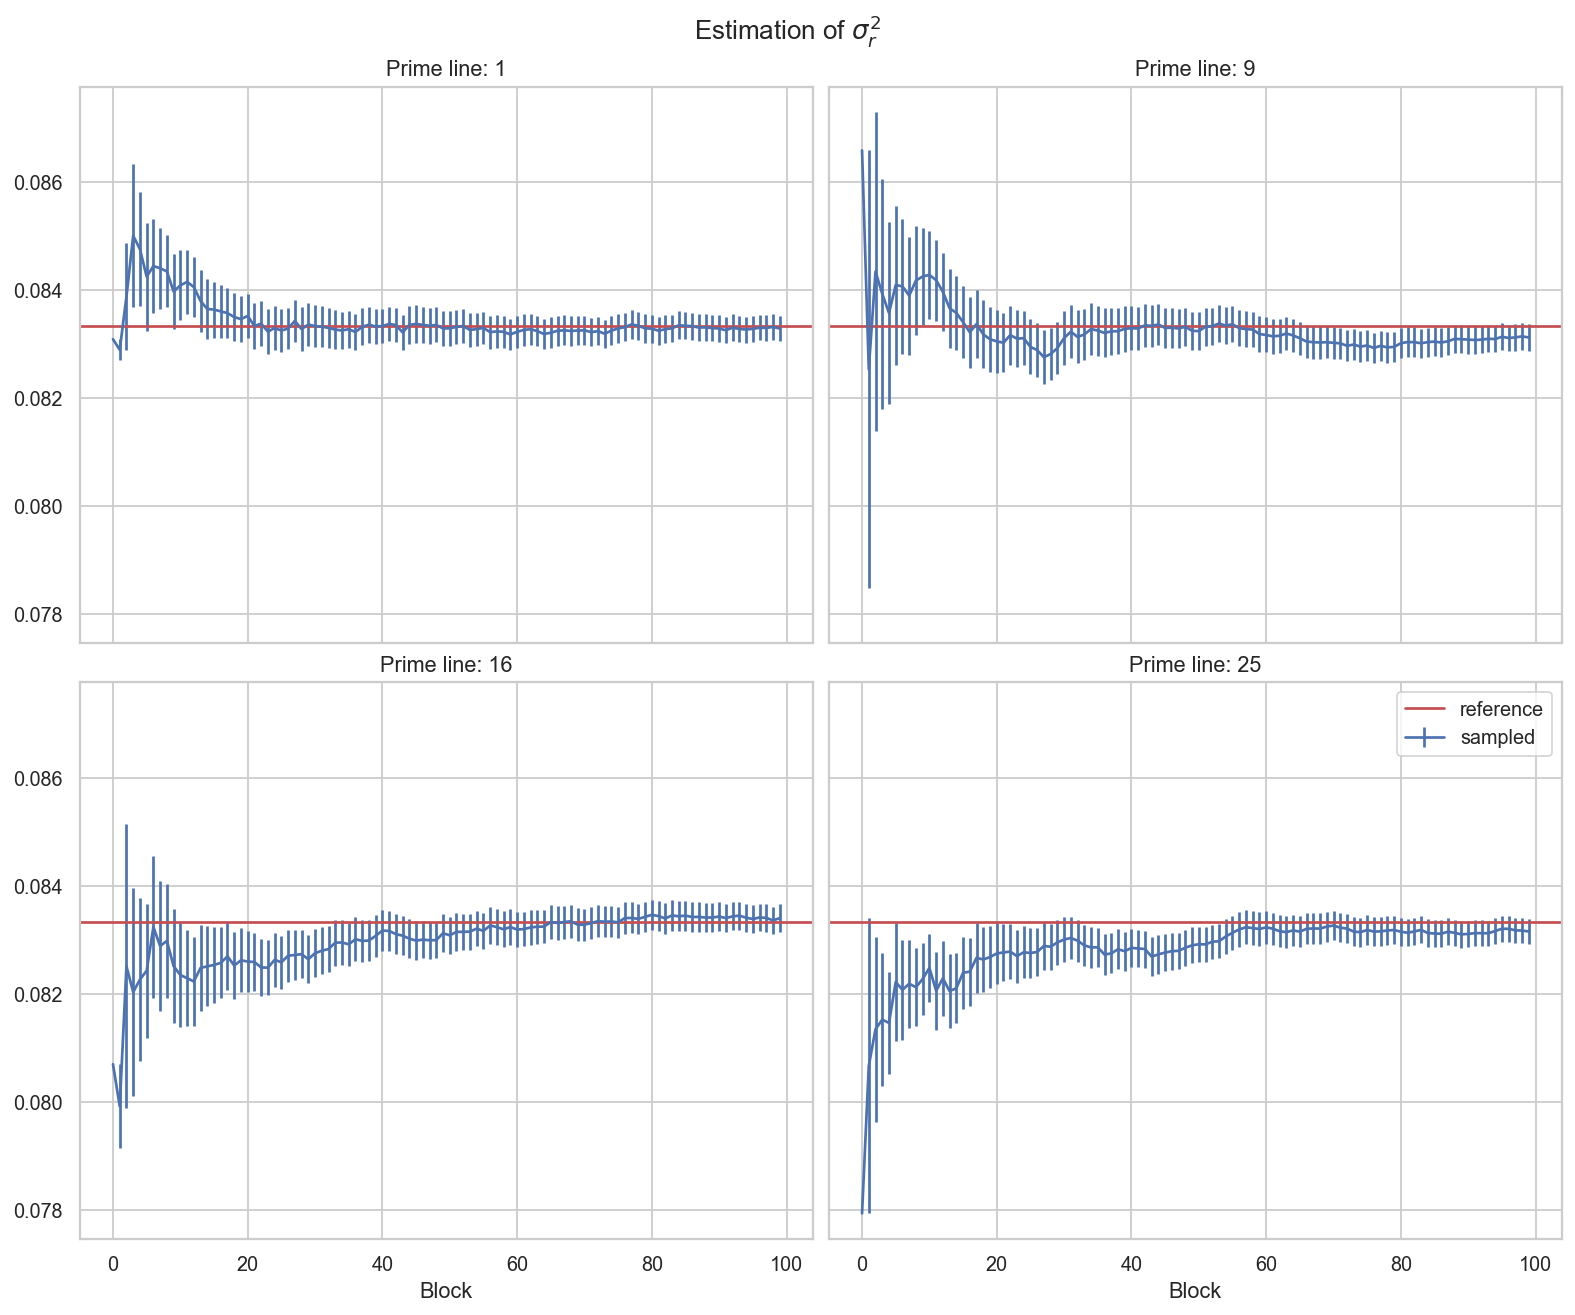

In [6]:
# Plotting four rounds of variance estimations
fig, axes = plt.subplots(
    2, 2, sharex=True, sharey=True, figsize=(12, 10), constrained_layout=True
)
for p_l, df, ax in zip(prime_lines, stats_data, axes.flatten()):
    ax.errorbar(
        "block",
        "variance_estimate",
        data=df.rename_axis(index=["block"]).reset_index(drop=False),
        yerr="variance_error",
        label="sampled",
    )
    ax.axhline(1 / 12, c="r", label="reference")
    ax.set_title(f"Prime line: {p_l}")
axes[1, 0].set_xlabel("Block")
axes[1, 1].set_xlabel("Block")
axes[1, 1].legend()
_ = fig.suptitle(r"Estimation of $\sigma^2_r$")


The plot shows that the estimation of $\sigma^2_r$ is compatible with the correct value of 1/12 for the prime lines searched.

### Pearson's $\chi^2$ distribution

We use the random generator to draw numbers in $\mathrm{N_{INTERVALS}}$ categories, and use the resulting counts to produce $\chi^2$ samples. We hypotesize the generator to be uniform, hence an estimated value of $\mathrm{E} = \mathrm{N_{TRIALS}}*\frac{1}{\mathrm{N_{INTERVALS}}}$ is used.

In [7]:
chi_df = (
    pd.concat(chi_data, keys=prime_lines, names=["prime_line", None])
    .reset_index(level="prime_line", drop=False)
    .reset_index()
    .astype({"prime_line": "category"})
)


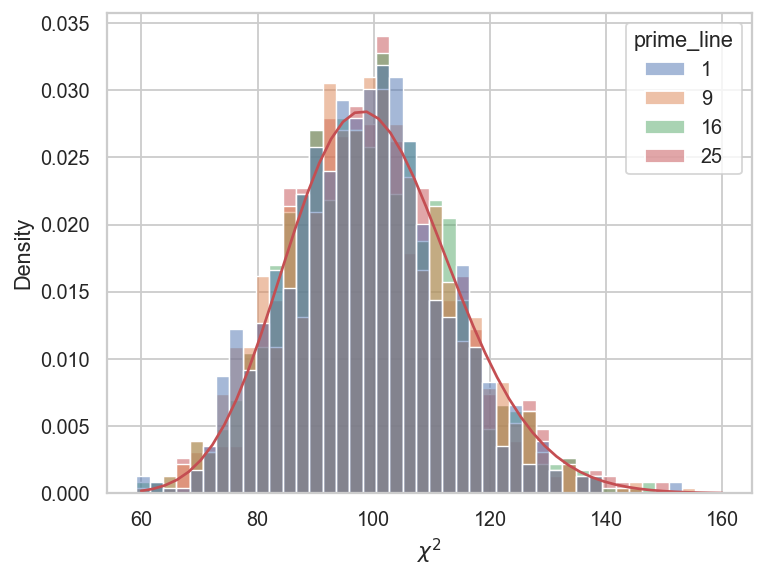

In [8]:
ax = sns.histplot(
    data=chi_df, x="X^2", hue="prime_line", stat="density", common_norm=False
)
xs = np.linspace(60, 160)
# Plotting a chi2 distribution with N_INTERVALS degrees of freedom
ax.plot(xs, stats.chi2(N_INTERVALS).pdf(xs), c="r", label="reference")
_ = ax.set_xlabel(r"$\chi^2$")


Comparing the histograms with the target pdf for $\mathrm{N_{INTERVALS}}$ degrees of freedom we get the idea that the hypotesis of having drawn samples form a uniform distribution is not absurd.

## Exercise 01.2

Checking the central limit theorem on some distributions using RANNYU as a source for pseudorandom numbers. Samples are drawn from three distributions (discrete uniform, exponential and cauchy) and are combined in four batches of averages $S_N = \frac{1}{N} \sum_i^N x_i$, with $N \in \{1,2,10,100\}$. The histograms of $S_N$ will be plotted. We expect the samples derived from the uniform and exponential distribution to converge to normal distributions, as they satisfy the central limit theorem's requirements. The cauchy distribution doesn't, so it should behave differently: being stable we expect it to maintain the same shape.

In [9]:
ex = "01_2"
# Path to the executable
executable = root / "bin" / ex
realizations_file = data_dir / f"{ex}.csv"

# The program is run using the following parameters:
N_REALIZATIONS = int(1e4)
proc.run(
    [
        executable,
        f"--primes_path={rng_dir/'primes'/'Primes'}",
        f"--seeds_path={rng_dir/'seeds'/'seed.in'}",
        f"--primes_line=2",
        f"--n_realizations={N_REALIZATIONS}",
        f"--out={realizations_file}",
    ]
)

# Pandas DataFrames storing the throws realizations. Some table formatting is in order
throws_data = pd.read_csv(realizations_file)
throws_data.columns = pd.MultiIndex.from_tuples(
    map(lambda t: (t[0], int(t[1])), throws_data.columns.str.split("_"))
)
throws_data = throws_data.sort_index(axis="columns").rename_axis(columns=["dice", "N"])


Parameters of the gaussian best fitting (MLE) the 100-average data: μ = 3.499, σ = 0.174

Statistics of the collected data:
N               1             2             10            100
count  10000.000000  10000.000000  10000.000000  10000.000000
mean       3.484300      3.497450      3.505650      3.499050
std        1.711212      1.207938      0.544576      0.173562
min        1.000000      1.000000      1.700000      2.890000
25%        2.000000      2.500000      3.100000      3.380000
50%        3.000000      3.500000      3.500000      3.500000
75%        5.000000      4.500000      3.900000      3.620000
max        6.000000      6.000000      5.400000      4.110000


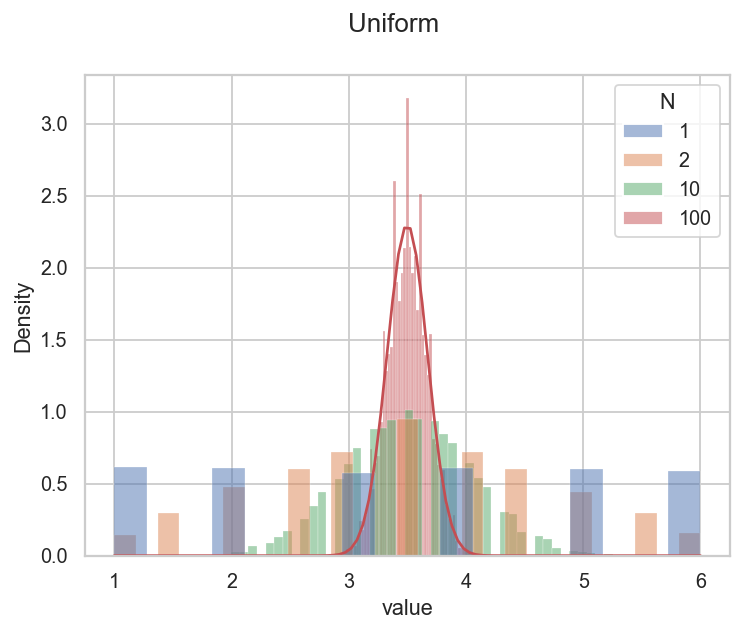

In [10]:
# Plotting data from the uniform samples
ax = sns.histplot(
    data=throws_data["uniform"].melt().astype({"N": "category"}),
    x="value",
    hue="N",
    common_bins=False,
    common_norm=False,
    stat="density",
)
params = stats.norm.fit(throws_data["uniform", 100])
xs = np.linspace(1, 6, 100)
ax.plot(xs, stats.norm(*params).pdf(xs), c="r")
ax.figure.suptitle("Uniform ")
print(
    f"Parameters of the gaussian best fitting (MLE) the 100-average data: \u03bc = {params[0]:.3f}, \u03c3 = {params[1]:.3f}\n"
)
print("Statistics of the collected data:")
print(throws_data["uniform"].describe())


The distributions of the averages behave as expected, converging to a gaussian with mean 3.5. The best-fit gaussian is plotted in red.

Parameters of the gaussian best fitting (MLE) the 100-average data: μ = 1.001, σ = 0.100

Statistics of the collected data:
N               1             2             10            100
count  10000.000000  10000.000000  10000.000000  10000.000000
mean       1.008671      1.005605      1.001999      1.000619
std        1.006035      0.716142      0.319137      0.099566
min        0.000129      0.001001      0.220343      0.694253
25%        0.292057      0.489271      0.770768      0.932262
50%        0.697570      0.846404      0.970015      0.997857
75%        1.391290      1.341282      1.194055      1.065873
max        9.234250      6.866200      2.634010      1.442310


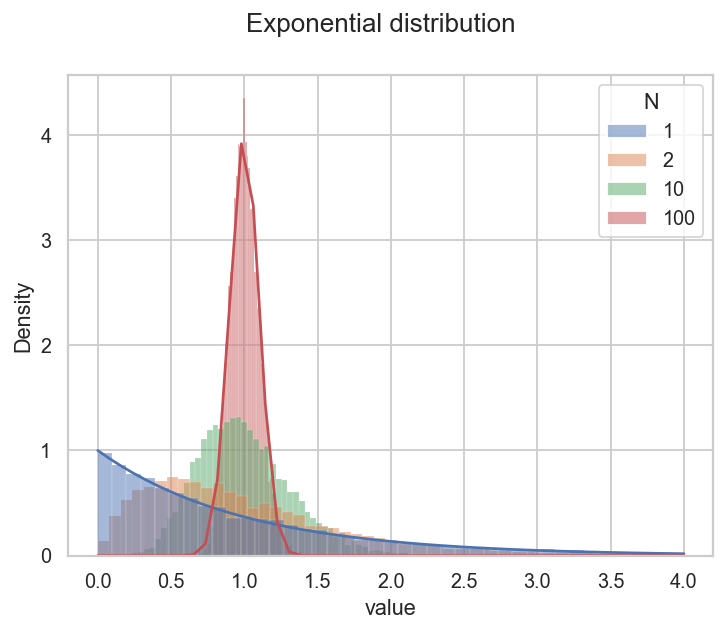

In [11]:
# Plotting the exponential dice throws
ax = sns.histplot(
    data=throws_data["exponential"].melt().astype({"N": "category"}),
    x="value",
    hue="N",
    # bins=50,
    common_bins=False,
    common_norm=False,
    stat="density",
    binrange=(0, 4),
)
# The exponential pdf with lambda = 1 is plotted as a blue line for reference
xs = np.linspace(0, 4)
ax.plot(xs, stats.expon(scale=1).pdf(xs), c="b")
params = stats.norm.fit(throws_data["exponential", 100])
ax.plot(xs, stats.norm(*params).pdf(xs), c="r")
ax.figure.suptitle("Exponential distribution")
print(
    f"Parameters of the gaussian best fitting (MLE) the 100-average data: \u03bc = {params[0]:.3f}, \u03c3 = {params[1]:.3f}\n"
)
print("Statistics of the collected data:")
print(throws_data["exponential"].describe())


Also for the exponential distribution we see the behaviour predicted by the central limit theorem.

Parameters of the Cauchy-Lorentz distribution best fitting (MLE) the 100-average data: μ = -0.012, σ = 1.004

Statistics of the collected data:
N               1              2             10            100
count  10000.000000   10000.000000  10000.000000  10000.000000
mean      -2.679330     -19.229212      0.643816      2.162868
std      280.676063    1915.941734     56.632016    245.394308
min   -26982.100000 -191517.000000  -2897.820000  -3850.480000
25%       -0.955368      -1.003090     -1.006557     -1.009288
50%        0.035654      -0.000623     -0.017115     -0.018325
75%        1.044402       1.032183      0.993058      1.003918
max     5531.510000    1734.360000   3154.480000  23944.000000


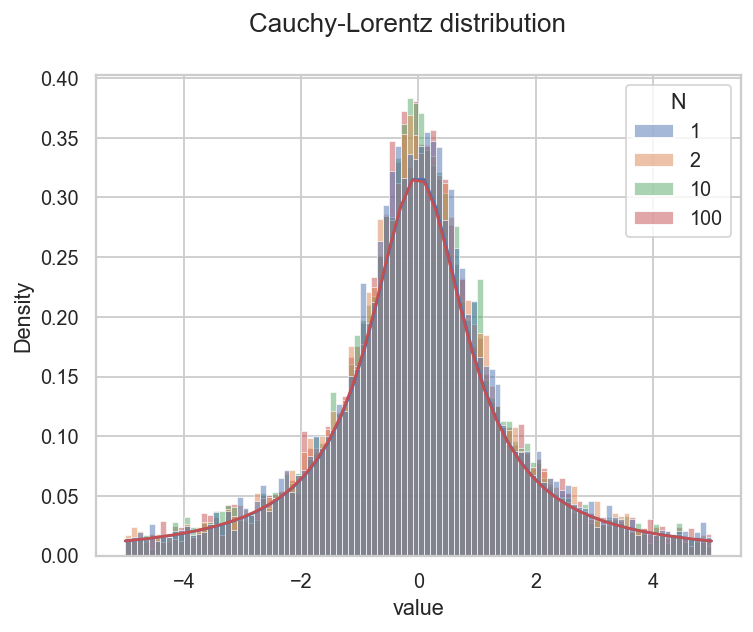

In [12]:
# Plotting data from the Cauchy-Lorentz distribution. Binning was restricted to the range (-5,5)
# for visualization purposes.
ax = sns.histplot(
    data=throws_data["lorentzian"].melt().astype({"N": "category"}),
    x="value",
    hue="N",
    common_bins=True,
    common_norm=False,
    stat="density",
    binrange=(-5, 5),
)
xs = np.linspace(-5, 5)
ax.plot(xs, stats.cauchy(loc=0, scale=1).pdf(xs), c="b")
# The Cauchy pdf with mu = 0 and gamma = 1, from which samples were drawn, is plotted as transform blue line for reference
params = stats.cauchy.fit(throws_data["lorentzian", 100])
ax.plot(xs, stats.cauchy(*params).pdf(xs), c="r")
ax.figure.suptitle("Cauchy-Lorentz distribution")
print(
    f"Parameters of the Cauchy-Lorentz distribution best fitting (MLE) the 100-average data: \u03bc = {params[0]:.3f}, \u03c3 = {params[1]:.3f}\n"
)
print("Statistics of the collected data:")
print(throws_data["lorentzian"].describe())


We observe the expected behavior. The MLE fit also shows an almost exact coincidence of parameters. Results in the statistics table reflects this distribution's lack of mean and standard deviation.

## Exercise 01.3

Estimating $\pi$ through the simulation of Buffon's needle throwing experiment. Two values for the number of throws will be compared.

In [35]:
ex = "01_3"

# Path to the executable
executable = root / "bin" / ex
pi_file = lambda n_throws: data_dir / f"{ex}_{n_throws}.csv"

# Two values for the number of throws will be compared
N_THROWS = [int(1e4), int(1e5)]
N_BLOCKS = 200
BLOCK_SIZE = 100

from tqdm.notebook import tqdm
# The program is run using the following parameters:
# Execution may take a while (~2min) as it samples a high number of points
for n_throws in tqdm(N_THROWS):
    proc.run(
        [
            executable,
            f"--primes_path={rng_dir/'primes'/'Primes'}",
            f"--seeds_path={rng_dir/'seeds'/'seed.in'}",
            f"--primes_line=1",
            f"--n_throws={n_throws}",
            f"--block_size={BLOCK_SIZE}",
            f"--n_rounds={N_BLOCKS}",
            f"--needle_length={0.3}",
            f"--lines_distance={1.0}",
            f"--out={pi_file(n_throws)}",
        ]
    )

# Pandas DataFrames storing pi estimations and uncertainties
pi_data = [pd.read_csv(pi_file(n_throws)) for n_throws in N_THROWS]


  0%|          | 0/2 [00:00<?, ?it/s]

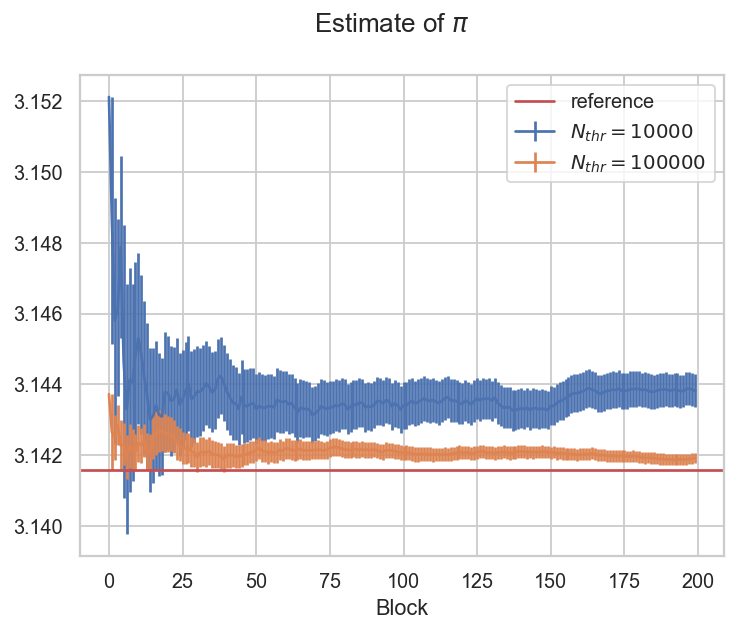

In [36]:
# Comparing the estimations using different values for n_throws
ax = plt.subplot(111)
for n_throw, df in zip(N_THROWS, pi_data):
    ax.errorbar(
        "index",
        "estimate",
        data=df.reset_index(drop=False),
        yerr="uncertainty",
        label=f"$N_{{thr}}={n_throw}$",
    )
ax.set_xlabel("Block")
ax.figure.suptitle(r"Estimate of $\pi$")
ax.axhline(np.pi, c="r", label="reference")
_ = ax.legend()


The results are comparable with the actual value of $\pi$, although they are not compatible within the margins of error. It seems though that incrementing the number of throws may lead to compatible results.